In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import catboost
from catboost import *
from region_entropy import find_optimal_region, sum_in_region
from region_visualizer import visualizer, create_bar_chart
from bucketing import compute_region
import matplotlib.pyplot as plt

In [2]:
file_path = './data/diabetes.csv'
df = pd.read_csv(file_path)

X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
cat_features_indices = [1]
cat_features_indices = []
model = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=12, cat_features=cat_features_indices, depth=6, l2_leaf_reg=3)
model.fit(X_train, y_train, verbose=False, plot=False)
# dfの['Predicted']列に予測結果を代入する
df['Predicted'] = model.predict(X)

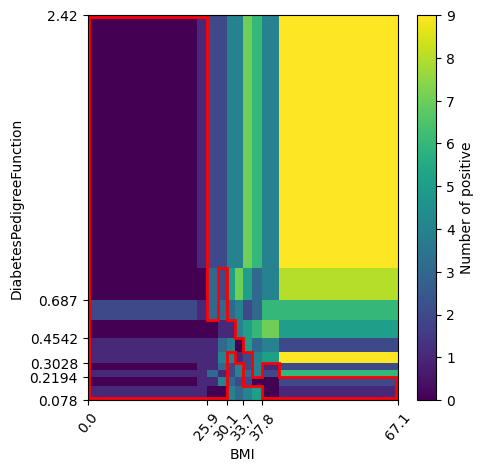

In [4]:
column_x, column_y = "DiabetesPedigreeFunction", "BMI"
_, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y, x_round=10,y_round=10)
points = positive
barlabel = "positive"
visualizer(
    points,
    region.bot,
    region.top,
    region.l,
    region.r,
    y_bucket_num,
    x_bucket_num,
    column_y,
    column_x,
    barlabel,
    ybins,
    xbins,
)

# points = negative
# barlabel = "negative"
# visualizer(
#     points,
#     region.bot,
#     region.top,
#     region.l,
#     region.r,
#     y_bucket_num,
#     x_bucket_num,
#     column_y,
#     column_x,
#     barlabel,
#     ybins,
#     xbins,
# )

# visualizer(
#     posandneg,
#     region.bot,
#     region.top,
#     region.l,
#     region.r,
#     y_bucket_num,
#     x_bucket_num,
#     column_y,
#     column_x,
#     'posandneg',
#     ybins,
#     xbins,
# )


In [5]:
# 全ての組み合わせを試す
check = True
#checkがTrueならこの処理を行う
if check:
    column_list = [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
    ]
    v_list = []
    for i in range(len(column_list)):
        for j in range(len(column_list)):
            if i == j:
                continue
            column_x = column_list[i]
            column_y = column_list[j]
            x_bucket_num = 10
            y_bucket_num = 10
            _, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y)
            v_list.append((column_x, column_y, v))

    v_list.sort(key=lambda x: x[2])
    print(v_list[:10])

[('Age', 'Glucose', 0.5029535214291367), ('Glucose', 'BMI', 0.5036939475294773), ('Glucose', 'Age', 0.5060425071309936), ('BMI', 'Glucose', 0.5108154117066779), ('Glucose', 'BloodPressure', 0.5244859518792953), ('Glucose', 'DiabetesPedigreeFunction', 0.5284700621746403), ('Pregnancies', 'Glucose', 0.5297935398397564), ('Glucose', 'Pregnancies', 0.5297935398397564), ('BloodPressure', 'Glucose', 0.5348022074668575), ('DiabetesPedigreeFunction', 'Glucose', 0.5348048819344404)]


In [6]:
# 多値分類タスクの場合は、positiveを特定のクラス、negativeをそれ以外のクラスとして扱う


## 説明が必要な特徴量ペアの検出

In [7]:
def detect_pairs_to_explain(df,variable_pairs, explain_index):
    pair_to_explain = []
    for column_x, column_y in variable_pairs:
        #print(column_x, column_y)
        df_with_bins, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y)
        instance_to_explain = df_with_bins.iloc[explain_index]

        point, v, region = find_optimal_region(positive, negative)
        # instance_to_explainがどのバケツに入るかを調べる
        x_bucket_index = sorted(df_with_bins["x_Bin"].unique().tolist()).index(instance_to_explain["x_Bin"])
        y_bucket_index = sorted(df_with_bins["y_Bin"].unique().tolist()).index(instance_to_explain["y_Bin"])

        # region.bot[x] <= y <= region.top[x], region.l <= x <= region.rならinstance_to_explainはregionに入る
        original_in_or_out = region.l <= y_bucket_index <= region.r and\
            region.bot[y_bucket_index] <= x_bucket_index <= region.top[y_bucket_index]
        # x,yを変動させた時に領域の境界を超えるかどうかを調べる
        x_crossed = False
        for i in range(y_bucket_num):
            pertubated_in_or_out = region.bot[i] <= x_bucket_index <= region.top[i] and\
                region.l <= i <= region.r
            if original_in_or_out != pertubated_in_or_out:
                x_crossed = True
                break
        y_crossed = False
        for i in range(x_bucket_num):
            pertubated_in_or_out = region.bot[y_bucket_index] <= i <= region.top[y_bucket_index] and\
                region.l <= y_bucket_index <= region.r
            if original_in_or_out != pertubated_in_or_out:
                y_crossed = True
                break
        need_explanation = x_crossed and y_crossed
        #print(need_explanation)
        if need_explanation:
            pair_to_explain.append((column_x, column_y))
    return pair_to_explain

v_pairs = []
for x,y,v in v_list:
    v_pairs.append((x,y))

detect_pairs_to_explain(df, v_pairs[:2], 3)


    

[('Age', 'Glucose')]

## 説明するインスタンスのハイライト

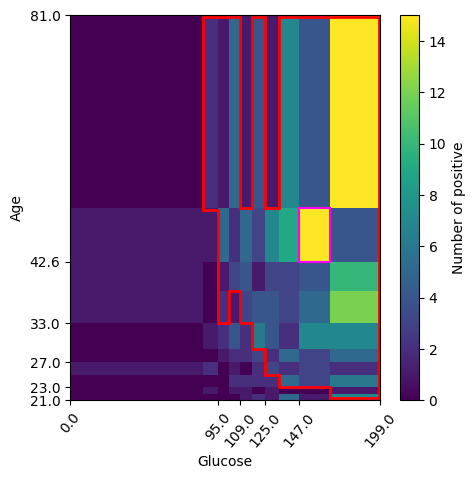

In [8]:
# ハイライト
def highlighten(df, pair_to_explain, explain_index, square=False):
    for column_x, column_y in pair_to_explain:
        objective_column = "Predicted"
        df_with_bins, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y)
        instance_to_explain = df_with_bins.iloc[explain_index]
        x_bucket_index = sorted(df_with_bins["x_Bin"].unique().tolist()).index(instance_to_explain["x_Bin"])
        y_bucket_index = sorted(df_with_bins["y_Bin"].unique().tolist()).index(instance_to_explain["y_Bin"])
        instance_to_explain = df_with_bins.iloc[explain_index]
        points = positive if instance_to_explain[objective_column] == 1 else negative
        barlabel = "positive" if instance_to_explain[objective_column] == 1 else "negative"
        visualizer(
            points,
            region.bot,
            region.top,
            region.l,
            region.r,
            y_bucket_num,
            x_bucket_num,
            column_y,
            column_x,
            barlabel,
            ybins,
            xbins,
            highlight=True,
            highlight_x=y_bucket_index,
            highlight_y=x_bucket_index,
            square=square,
        )
v_pairs = []
for x,y,v in v_list[:1]:
    v_pairs.append((x,y))
highlighten(df, v_pairs[:1], 0)

## 説明器の作成

In [9]:
file_path = './data/diabetes.csv'
df = pd.read_csv(file_path)

X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_features_indices = [1]
cat_features_indices = []
model = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=12, cat_features=cat_features_indices, depth=6, l2_leaf_reg=3)
model.fit(X_train, y_train, verbose=False, plot=False)
# dfの['Predicted']列に予測結果を代入する
df['Predicted'] = model.predict(X)

Text(0, 0.5, 'accuracy')

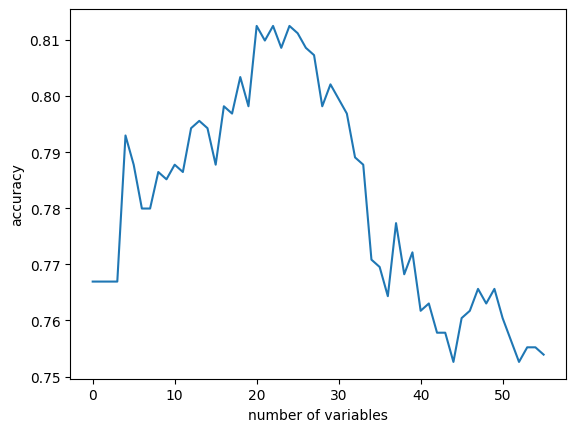

In [10]:
df['majority'] = 0

accuracy_list = []

for column_x, column_y, _ in v_list:
    objective_column = "Predicted"
    x_round = 2 if column_x == "DiabetesPedigreeFunction" else 1
    y_round = 2 if column_y == "DiabetesPedigreeFunction" else 1
    df_with_bins, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y, x_round=x_round, y_round=y_round)
    # dfの各インスタンスに対して処理を行う
    for i in range(len(df)):
        instance_to_explain = df.iloc[i]
        # instance_to_explainがどのバケツに入るかを調べる
        x_bucket_index = sorted(df_with_bins["x_Bin"].unique().tolist()).index(instance_to_explain["x_Bin"])
        y_bucket_index = sorted(df_with_bins["y_Bin"].unique().tolist()).index(instance_to_explain["y_Bin"])
        
        in_region = region.l <= y_bucket_index <= region.r and\
            region.bot[y_bucket_index] <= x_bucket_index <= region.top[y_bucket_index]
        positive_all = (df[objective_column] == 1).sum()
        positive_in_region = sum_in_region(region, positive)
        negative_in_region = sum_in_region(region, negative)
        if positive_all/len(df) < positive_in_region/(positive_in_region+negative_in_region):
            # regionは陽性のインスタンスが多い
            if in_region:
                # ['majority']の値に1000-vを足す。ただ代入するのではなく、元の値に加算する
                df.loc[i, 'majority'] += 100-v
            else:
                df.loc[i, 'majority'] -= 100-v
        else:
            # regionは陰性のインスタンスが多い
            if in_region:
                df.loc[i, 'majority'] -= 100-v
            else:
                df.loc[i, 'majority'] += 100-v
    # df['majority']の値が正なら陽性、負なら陰性と予測する
    df['Explainer'] = df['majority'] > 0
    accuracy_list.append(accuracy_score(df['Predicted'], df['Explainer']))

# 説明器が使った変数の数と精度の推移をグラフにする
plt.plot(accuracy_list)
plt.xlabel("number of variables")
plt.ylabel("accuracy")

[('Age', 'Glucose'), ('Glucose', 'BloodPressure'), ('Glucose', 'SkinThickness'), ('SkinThickness', 'Glucose'), ('BMI', 'DiabetesPedigreeFunction'), ('BMI', 'Pregnancies'), ('Age', 'DiabetesPedigreeFunction')]
0.8125


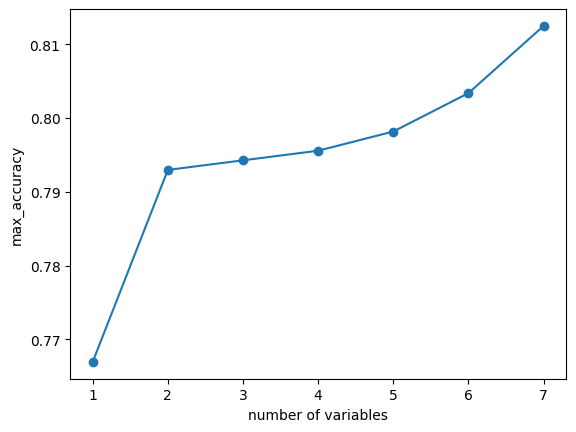

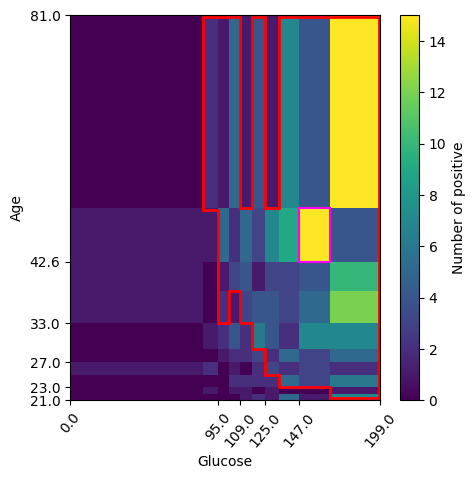

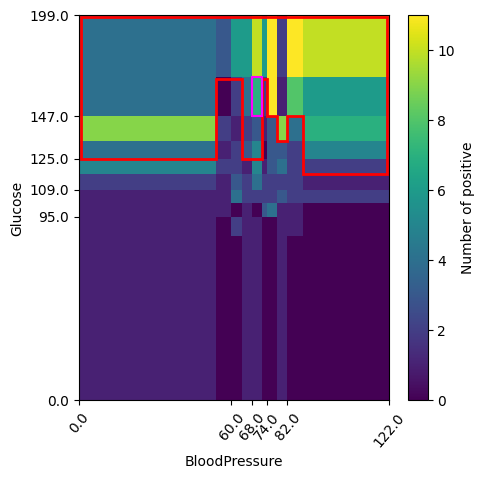

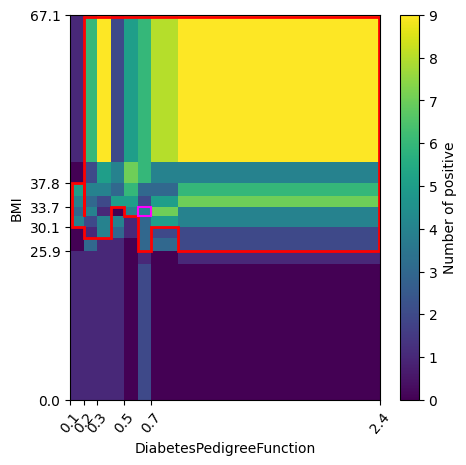

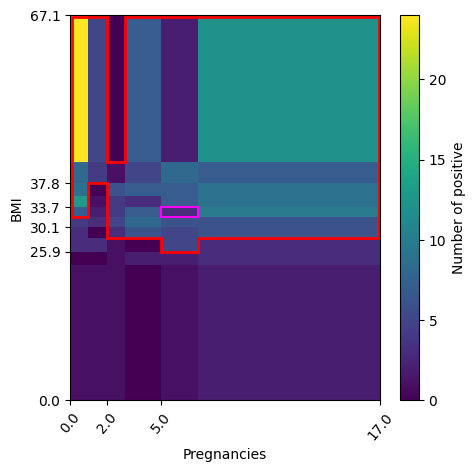

In [11]:
# 説明器に使うと精度が上がった変数のみを使って説明器を作る
df['majority'] = 0

max_accuracy = 0
max_accuracy_list = []
variable_list = []
for column_x, column_y, _ in v_list:
    df_with_bins, region, v, xbins, ybins, positive, negative, posandneg, x_bucket_num, y_bucket_num = compute_region(df, column_x, column_y, x_round=3, y_round=3)
    # dfの各インスタンスに対して処理を行う
    for i in range(len(df)):
        instance_to_explain = df.iloc[i]
        # instance_to_explainがどのバケツに入るかを調べる
        x_bucket_index = sorted(df_with_bins["x_Bin"].unique().tolist()).index(instance_to_explain["x_Bin"])
        y_bucket_index = sorted(df_with_bins["y_Bin"].unique().tolist()).index(instance_to_explain["y_Bin"])
        
        in_region = region.l <= y_bucket_index <= region.r and\
            region.bot[y_bucket_index] <= x_bucket_index <= region.top[y_bucket_index]
        positive_all = (df[objective_column] == 1).sum()
        positive_in_region = sum_in_region(region, positive)
        negative_in_region = sum_in_region(region, negative)
        if positive_all/len(df) < positive_in_region/(positive_in_region+negative_in_region):
            # regionは陽性のインスタンスが多い
            if in_region:
                # ['majority']の値に1000-vを足す。ただ代入するのではなく、元の値に加算する
                df.loc[i, 'majority'] += 100-v
            else:
                df.loc[i, 'majority'] -= 100-v
        else:
            # regionは陰性のインスタンスが多い
            if in_region:
                df.loc[i, 'majority'] -= 100-v
            else:
                df.loc[i, 'majority'] += 100-v
    # df['majority']の値が正なら陽性、負なら陰性と予測する
    df['Explainer'] = df['majority'] > 0
    accuracy = accuracy_score(df['Predicted'], df['Explainer'])
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_accuracy_list.append(max_accuracy)
        variable_list.append((column_x, column_y))
    else:
        # 精度が下がったらその変数の値をmajorityから引く
        if positive_all/len(df) < positive_in_region/(positive_in_region+negative_in_region):
            # regionは陽性のインスタンスが多い
            if in_region:
                # ['majority']の値に1000-vを足す。ただ代入するのではなく、元の値に加算する
                df.loc[i, 'majority'] -= 100-v
            else:
                df.loc[i, 'majority'] += 100-v
        else:
            # regionは陰性のインスタンスが多い
            if in_region:
                df.loc[i, 'majority'] += 100-v
            else:
                df.loc[i, 'majority'] -= 100-v
# 説明器に使った変数の数と精度の推移をグラフにする
plt.plot(max_accuracy_list, marker='o')
plt.xlabel("number of variables")
plt.ylabel("max_accuracy")
# x軸のラベルのを[1,2,3...]にする
plt.xticks(np.arange(len(max_accuracy_list)), np.arange(1, len(max_accuracy_list)+1))
print(variable_list)
print(max_accuracy)
highlight_list = detect_pairs_to_explain(df, variable_list, 0)
highlighten(df, highlight_list, 0)

In [12]:
print(df.iloc[0])

Pregnancies                            6
Glucose                              148
BloodPressure                         72
SkinThickness                         35
Insulin                                0
BMI                                 33.6
DiabetesPedigreeFunction           0.627
Age                                   50
Outcome                                1
Predicted                              1
majority                     5368.725272
x_Bin                       (32.0, 33.7]
y_Bin                         (5.0, 7.0]
Explainer                           True
Name: 0, dtype: object
